In [1]:
'''this script is used to evaluate the trained net on the test set'''
import numpy as np
import sys
import gc

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

caffe_root='/home/zyan3/proj/caffe-private-recurrent_2d/'
sys.path.insert(0, caffe_root + 'python')
import caffe
import os
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import skimage.transform
import time

In [11]:
# Set the right path to your model definition file, pretrained model weights,
layer_dir=caffe_root+'examples/voc12_SBD/VGG_16_layer_renet/'
model_name = 'VGG_16_layer_fc8_fast_LR_hole_renet_2_lay_5xLR_lr1e-3'
iter_num = 6000
MODEL_FILE = caffe_root+\
'examples/voc12_SBD/VGG_16_layer_fc8_fast_LR_hole_renet_2_lay_5xLR_deploy.prototxt'
PRETRAINED =layer_dir +'%s_iter_%d.caffemodel'%(model_name, iter_num)

net_input_multiple = [1,1]

label_names=['background','aeroplane','bicycle','bird','boat','bottle',\
'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',\
'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',\
'train', 'tvmonitor','unknown']
num_label=22

print 'MODEL_FILE: %s' % MODEL_FILE
print 'PRETRAINED : %s' % PRETRAINED

MODEL_FILE: /home/zyan3/proj/caffe-private-recurrent_2d/examples/voc12_SBD/VGG_16_layer_fc8_fast_LR_hole_renet_2_lay_5xLR_deploy.prototxt
PRETRAINED : /home/zyan3/proj/caffe-private-recurrent_2d/examples/voc12_SBD/VGG_16_layer_renet/VGG_16_layer_fc8_fast_LR_hole_renet_2_lay_5xLR_lr1e-3_iter_6000.caffemodel


In [12]:
caffe.set_mode_gpu()
caffe.set_device(0)
net = caffe.Net(MODEL_FILE, PRETRAINED, caffe.TEST)

In [13]:
[ (layer, net.blobs[layer].data.shape) for layer in net.blobs]

[('data', (1, 3, 320, 320)),
 ('image-size', (1, 1, 1, 2)),
 ('conv1_1', (1, 64, 320, 320)),
 ('conv1_2', (1, 64, 320, 320)),
 ('pool1', (1, 64, 160, 160)),
 ('conv2_1', (1, 128, 160, 160)),
 ('conv2_2', (1, 128, 160, 160)),
 ('pool2', (1, 128, 80, 80)),
 ('conv3_1', (1, 256, 80, 80)),
 ('conv3_2', (1, 256, 80, 80)),
 ('conv3_3', (1, 256, 80, 80)),
 ('pool3', (1, 256, 40, 40)),
 ('conv4_1', (1, 512, 40, 40)),
 ('conv4_2', (1, 512, 40, 40)),
 ('conv4_3', (1, 512, 40, 40)),
 ('pool4', (1, 512, 39, 39)),
 ('conv5_1', (1, 512, 39, 39)),
 ('conv5_2', (1, 512, 39, 39)),
 ('conv5_3', (1, 512, 39, 39)),
 ('renet_lstm_6_vertical', (1, 80, 39, 39)),
 ('renet_lstm_6_horizontal', (1, 80, 39, 39)),
 ('conv6', (1, 80, 39, 39)),
 ('renet_lstm_7_vertical', (1, 120, 39, 39)),
 ('renet_lstm_7_horizontal', (1, 120, 39, 39)),
 ('conv7', (1, 21, 39, 39)),
 ('conv7_full_res', (1, 21, 1, 1)),
 ('prob', (1, 21, 1, 1))]

In [6]:
[ (k, v[0].data.shape) for k,v in net.params.items()]

OverflowError: long int too large to convert to int

In [7]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)
    plt.axis('off')
    
def vis_renet_lstm(lstm_params):
    filters=lstm_params[0].data
    filters=filters[:,:27]
    n_filters=filters.shape[0]
    filters=filters.reshape((n_filters, 3, 3, 3))
    print filters.shape
    vis_square(filters)    
    
def show_label_map(label_map):
    ''' to extend the color map to the full range [0,8]
        assign label 0 to a pixel in the corner
        assign label 8 to a pixel in the corner
    '''
    label_map_copy = np.copy(label_map)
    label_map_copy[0,0]=0
    label_map_copy[-1,-1]=num_label-1
    plt.imshow(label_map_copy, cmap='jet')
    plt.axis('off')    
#     cbar=plt.colorbar(ticks=np.arange(num_label))
#     cbar.ax.set_yticklabels(label_names)

'''
label 255 denotes "difficult" pixels
relabel it to 21.
label "0" denotes background label
labes 1 ~ 20 denote foreground object labels
'''
def read_label_file(label_file_path):
    with open(label_file_path) as f:
        lines = f.readlines()
        height=len(lines)
        width = len(lines[0].split(' '))
        label_map=np.zeros((height,width),dtype=np.int32)
        for y in range(height):
            row_labels = lines[y].split(' ')
            for x in range(width):
                read_label = int(row_labels[x])
                label_map[y,x] = 21 if read_label == 255 else read_label
        return label_map
    
''' pad image so that its height and width are multiples of the given scalar
'''
def pad_image(image, image_multiple):
    out_height = np.ceil(float(image.shape[0]) / float(image_multiple[0])) * image_multiple[0]
    out_width = np.ceil(float(image.shape[1]) / float(image_multiple[1])) * image_multiple[1]
    out_img = np.zeros((out_height, out_width, image.shape[2]))
    out_img[:image.shape[0],:image.shape[1],:]=image
    if out_height > image.shape[0]:
        bottom_border = image[image.shape[0]-1,:,:]
        out_img[image.shape[0]:, :image.shape[1], :] = bottom_border[np.newaxis,:,:]
    if out_width > image.shape[1]:
        right_border = image[:,image.shape[1] - 1,:]
        out_img[:image.shape[0],image.shape[1]:,:]=right_border[:,np.newaxis,:]
    if out_height > image.shape[0] and out_width > image.shape[1]:
        right_bottom_corner = image[-1,-1,:]
        out_img[image.shape[0]:, image.shape[1]:, :] = right_bottom_corner[np.newaxis,np.newaxis,:]

    return out_img

def process_label_map(label_map, num_label):
    ''' For visualization purpose, extend the color map to the full range [0,8]
        assign label 0 to a pixel in the corner
        assign label 8 to a pixel in the corner
    '''    
    label_map[0,0]=0
    label_map[-1,-1]=num_label-1
    return label_map

In [8]:
data_dir='/home/zyan3/local/data/voc12_SBD/'
img_dir=data_dir+'img/'
label_dir=data_dir+'SegmentationClassText/'
test_list=data_dir+'val.txt'

test_img_names=[]
with open(test_list) as f:
    for line in f.readlines():
        test_img_names += [line[:-1]]

In [9]:
'''data transform parameters'''
data_mean=np.array([104,117,123])
# input_scale = 0.0078125
input_scale = 1.0

In [14]:
'''For VGG-based net,  evaluate on the test set'''
visualize_result = True

pred_label_image_save_dir = layer_dir + model_name + '_prediction/'
if not os.path.exists(pred_label_image_save_dir):
    os.mkdir(pred_label_image_save_dir)


class_agnostic_pix_correct = 0.0
class_agnostic_pix_total = 0.0
class_pix_correct = np.zeros((num_label))
class_pix_total = np.zeros((num_label))

st_time = time.time()

'''the last label 'unknown' is ignored  '''
confcounts = np.zeros(( (num_label - 1)**2 ))

for i in range(len(test_img_names)):
# for i in range(3):
    if i % 100 == 0:
        ep_time = time.time() - st_time
        st_time = time.time()        
        print 'process %d out of %d images' % (i, len(test_img_names))
        print 'elapsed time %4.2f' % ep_time
        if i > 0:
            pixel_accu = class_agnostic_pix_correct/class_agnostic_pix_total
            class_accu = class_pix_correct / class_pix_total
            print 'test set pixel accuracy %4.2f' % (pixel_accu*100.0)
            print 'test set class accuracy %4.2f' % (np.mean(class_accu)*100.0)

    test_img_name = test_img_names[i]
#     print 'test image name %s' % test_img_name
    test_img = caffe.io.load_image(img_dir+test_img_name+'.jpg')
#     print 'test_img_name shape ', test_img.shape
    in_height, in_width = test_img.shape[0], test_img.shape[1]
        
    transformer = caffe.io.Transformer({'data': [1, 3, in_height, in_width]})
    transformer.set_transpose('data', (2,0,1))
    transformer.set_mean('data', data_mean) # mean pixel
    transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
    transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
    transformer.set_input_scale('data', input_scale)  
    
    net.blobs['data'].reshape(1, 3, in_height, in_width)
    net.blobs['data'].data[...] = transformer.preprocess('data', test_img)
    
    net.blobs['image-size'].data[...] = np.array([in_height, in_width])
    
    
    
    out = net.forward()
    
    '''  ground truth label '''
    gt_label = read_label_file(label_dir + test_img_name + '.txt')
    locs = np.nonzero(gt_label != (num_label -1) )
    ''' predicted label '''
    pred_label=np.argmax(net.blobs['prob'].data[0,:,:,:],axis=0)
    pred_label = pred_label[:in_height, :in_width]
    
    assert np.max(pred_label) < num_label
    assert gt_label.shape == pred_label.shape
    
    '''Intersection over Union'''
    sumim = gt_label[locs] + pred_label[locs] * (num_label - 1)
    hs,bins=np.histogram(sumim, np.arange(0, (num_label-1)**2 + 1))
    confcounts[:]=confcounts[:]+hs 
    
    ''' pixelwise / classwise accuracy '''
    pred_correct = pred_label == gt_label
    lc_class_agnostic_pix_correct = np.sum(pred_correct)
    lc_class_agnostic_pix_total = in_height * in_width
    class_agnostic_pix_correct += lc_class_agnostic_pix_correct
    class_agnostic_pix_total += lc_class_agnostic_pix_total
    lc_pixel_accu = (float(lc_class_agnostic_pix_correct) / float(lc_class_agnostic_pix_total))
    
#     print 'lc_class_agnostic_pix_correct ',lc_class_agnostic_pix_correct
#     print 'lc_class_agnostic_pix_total ',lc_class_agnostic_pix_total
#     print 'pixel accuracy %f ' % (lc_pixel_accu)
    
    for l in range(num_label):
        idx = np.nonzero(gt_label == l)
        class_pix_correct[l] += np.sum(pred_correct[idx[0], idx[1]])
        class_pix_total[l]+= len(idx[0])
                            
            
    if visualize_result:
        gt_label=process_label_map(gt_label, num_label)
        pred_label=process_label_map(pred_label, num_label)
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[20, 10])

        im1 = ax1.imshow(test_img)
        ax1.axes.get_xaxis().set_visible(False)
        ax1.axes.get_yaxis().set_visible(False)    
        ax1.set_title('input')

        im2 = ax2.imshow(pred_label, cmap='jet')
        ax2.axes.get_xaxis().set_visible(False)
        ax2.axes.get_yaxis().set_visible(False)
        ax2.set_title('prediction, pix accuracy: %4.2f' % (lc_pixel_accu*100))

        im3 = ax3.imshow(gt_label, cmap='jet')
        ax3.axes.get_xaxis().set_visible(False)
        ax3.axes.get_yaxis().set_visible(False)
        ax3.set_title('groundtruth')

        axins = inset_axes(ax3,
                           width="5%", # width = 10% of parent_bbox width
                           height="100%", # height : 50%
                           loc=3,
                           bbox_to_anchor=(1.05, 0., 1, 1),
                           bbox_transform=ax3.transAxes,
                           borderpad=0)

        cbar=plt.colorbar(im3, ticks=np.arange(num_label), cax=axins)
        cbar.ax.set_yticklabels(label_names)   

        plt.savefig(pred_label_image_save_dir+test_img_name+'.jpg', bbox_inches='tight')

        del im1, im2, im3, axins, cbar
        fig.clf()
        plt.close()
        del gt_label, pred_label
        gc.collect()

assert class_agnostic_pix_total == np.sum(class_pix_total)

print 'overall summary:'
pixel_accu = class_agnostic_pix_correct/class_agnostic_pix_total
class_accu = class_pix_correct / class_pix_total
print 'test set pixel accuracy %4.2f' % (pixel_accu*100.0)
print 'test set class accuracy %4.2f' % (np.mean(class_accu)*100.0)


IoU=np.zeros((num_label-1))
confcounts = confcounts.reshape((num_label-1,num_label-1))
for i in range(num_label-1):
    gt_i=np.sum(confcounts[:,i])
    pred_i=np.sum(confcounts[i,:])
    gt_pred_i=confcounts[i,i]
    IoU[i]=np.float(gt_pred_i)/np.float(gt_i+pred_i-gt_pred_i)
print 'IoU accuracies'
print IoU
print 'Mean IoU %5.4f' % (np.mean(IoU))

process 0 out of 1449 images
elapsed time 0.00
process 100 out of 1449 images
elapsed time 80.40
test set pixel accuracy 82.53
test set class accuracy 52.01
process 200 out of 1449 images
elapsed time 77.30
test set pixel accuracy 83.05
test set class accuracy 56.46
process 300 out of 1449 images
elapsed time 83.97
test set pixel accuracy 82.51
test set class accuracy 56.71
process 400 out of 1449 images
elapsed time 76.33
test set pixel accuracy 83.39
test set class accuracy 57.14
process 500 out of 1449 images
elapsed time 78.49
test set pixel accuracy 83.77
test set class accuracy 58.29
process 600 out of 1449 images
elapsed time 81.36
test set pixel accuracy 83.66
test set class accuracy 59.21
process 700 out of 1449 images
elapsed time 83.73
test set pixel accuracy 83.88
test set class accuracy 59.82
process 800 out of 1449 images
elapsed time 83.82
test set pixel accuracy 83.83
test set class accuracy 59.51
process 900 out of 1449 images
elapsed time 82.00
test set pixel accuracy

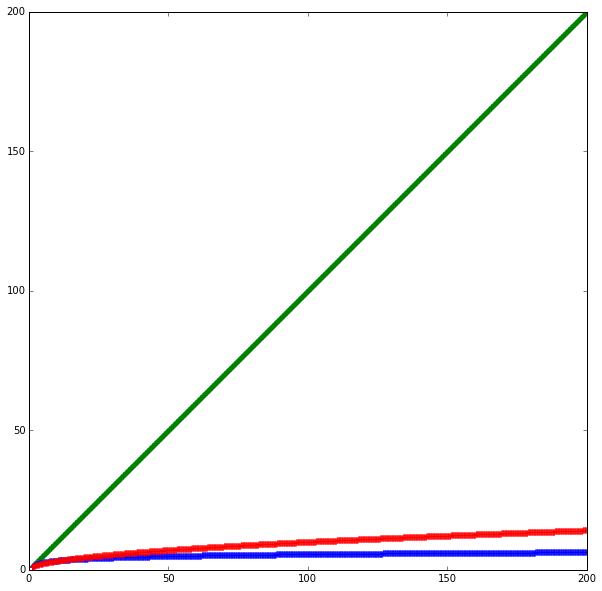

In [16]:
x=np.arange(1, 200.0, 0.1)
y0=x
y1=np.log(x) + 1.0
y2=np.sqrt(x)

plt.plot(x,y0,'g+')
plt.hold(True)
plt.plot(x,y1,'b+')
plt.hold(True)
plt.plot(x,y2,'r+')

test image name 2007_002719
test_img_name shape  (374, 500, 3)
padded_img shape (375, 500, 3)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


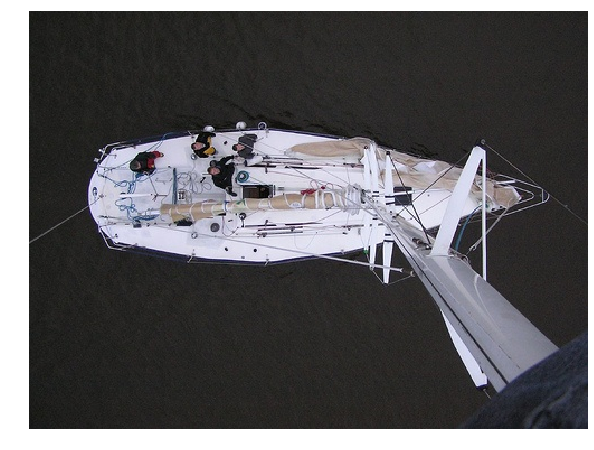

In [10]:
'''cells below include codes for case studies (a.k.a individual test images)'''
test_img_name = test_img_names[88]
print 'test image name %s' % test_img_name
test_img = caffe.io.load_image(img_dir+test_img_name+'.jpg')
print 'test_img_name shape ', test_img.shape
plt.axis('off')
plt.imshow(test_img)

padded_img = pad_image(test_img,net_input_multiple)
print 'padded_img shape', padded_img.shape

In [11]:
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': [1, 3, padded_img.shape[0], padded_img.shape[1]]})
# transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', data_mean) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
transformer.set_input_scale('data', input_scale)

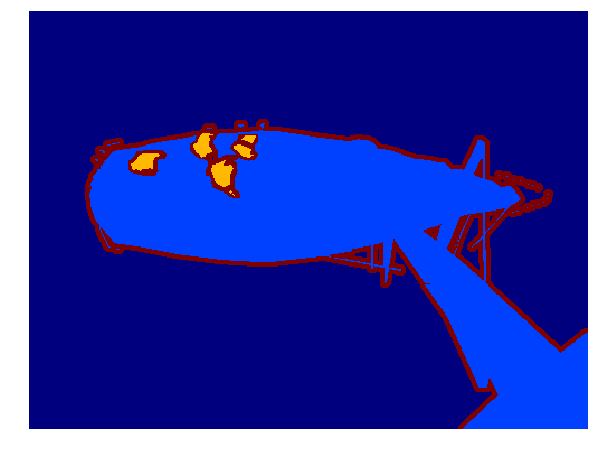

In [12]:
label_map = read_label_file(label_dir + test_img_name + '.txt')
show_label_map(process_label_map(label_map, num_label))

(22, 375, 500)


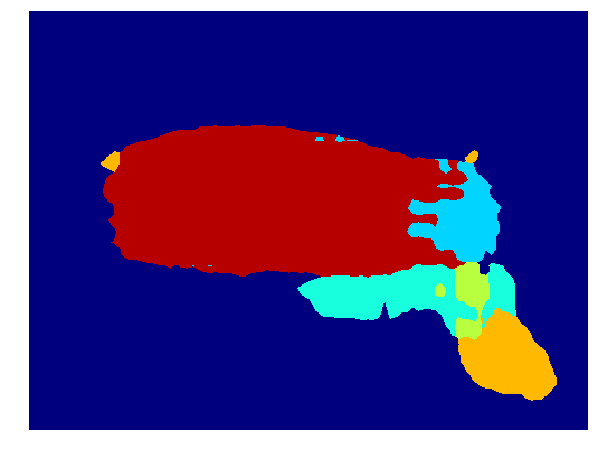

In [13]:
net.blobs['data'].reshape(1, 3, padded_img.shape[0], padded_img.shape[1])
net.blobs['data'].data[...] = transformer.preprocess('data', padded_img)
out = net.forward()
print net.blobs['prob'].data[0,:,:,:].shape
pred_label_map=np.argmax(net.blobs['prob'].data[0,:,:,:],axis=0)
show_label_map(process_label_map(pred_label_map,num_label))

(160, 111, 167)


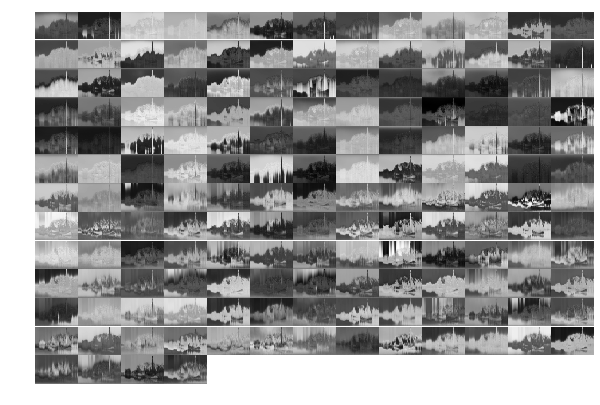

In [35]:
ftr_map=net.blobs['renet_lstm_1_vertical'].data[0,:,:,:]
print ftr_map.shape
vis_square(ftr_map,padval=1)

(160, 111, 167)


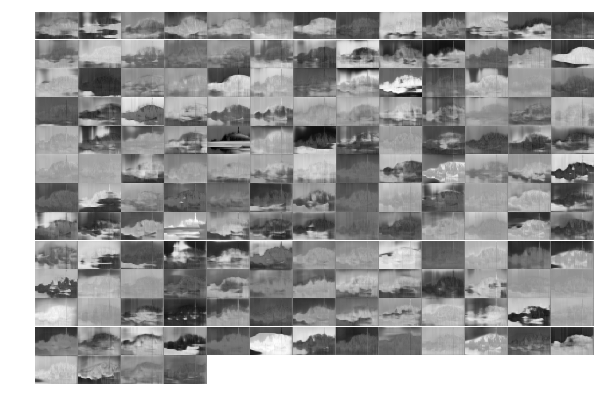

In [36]:
ftr_map=net.blobs['renet_lstm_1_horizontal'].data[0,:,:,:]
print ftr_map.shape
vis_square(ftr_map,padval=1)

(22, 111, 167)


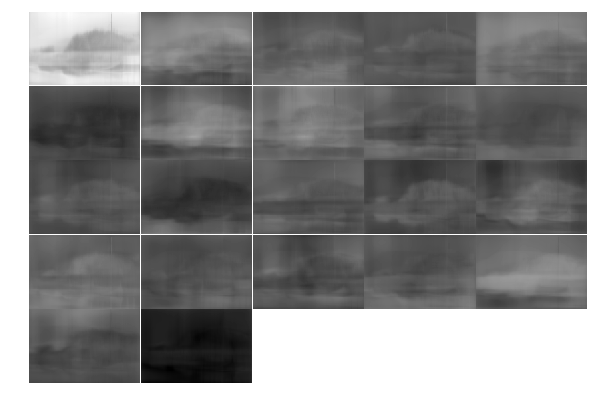

In [37]:
ftr_map=net.blobs['conv1'].data[0,:,:,:]
print ftr_map.shape
vis_square(ftr_map,padval=1)

(22, 333, 501)


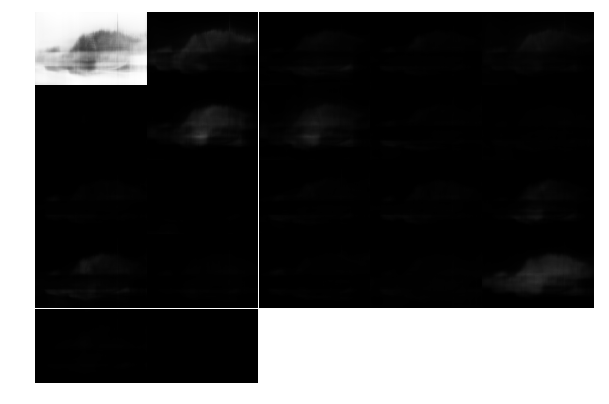

In [38]:
ftr_map=net.blobs['prob'].data[0,:,:,:]
print ftr_map.shape
vis_square(ftr_map,padval=1)